# BTC-USD @5min - LSTM (close) full runs

In [1]:
# PARAMS:
BC5M_FILENAME = './data_clean/btc.300s.cbpro.csv'
OUT_FILENAME = './results/btc5min_c.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [2]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [3]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


> size: 387948


datetime    datetime64[ns]
low                float64
high               float64
open               float64
close              float64
volume             float64
dtype: object

datetime     low    high    open   close      volume
timestamp                                                                 
1422745200 2015-01-31 23:00:00  224.51  225.69  225.38  224.51   29.638700
1422745500 2015-01-31 23:05:00  224.00  225.59  224.62  224.00   52.189176
1422745800 2015-01-31 23:10:00  221.99  223.92  223.91  221.99   40.262566
1422746100 2015-01-31 23:15:00  218.00  222.00  222.00  218.00  163.490760
1422746400 2015-01-31 23:20:00  217.11  218.89  217.92  218.22   96.317898

datetime      low     high     open    close     volume
timestamp                                                                    
1539128100 2018-10-09 23:35:00  6590.30  6593.48  6591.54  6590.30  17.148190
1539128400 2018-10-09 23:40:00  6586.55  6590.31  6590.31  6589.30  15.269094
1539128700 2018-10-09 23:45:00  6589.29  6589.69  6589.30  6589.48  12.466310
1539129000 2018-10-09 23:50:00  6589.47  6592.81  6589.48  6591.85  14.972801
1539129300 2018-10-09 23:55:00  6589.47  6592.81  6591.84  6589.48  31.305392

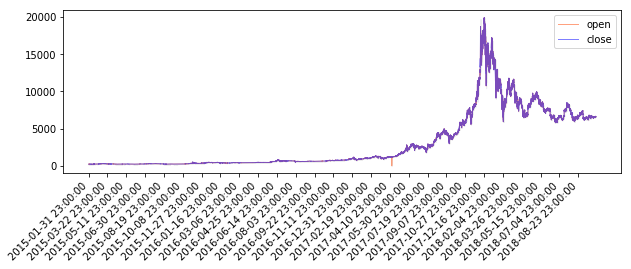

In [5]:
data5m = pd.read_csv(
    BC5M_FILENAME,
    index_col='timestamp',
    parse_dates=['datetime']
)
print('> size:', len(data5m))
dd(data5m.dtypes)
dd(data5m.head())
dd(data5m.tail())
simple_plot(data5m, xticks_span=30 * 24 * 60 // 3)

## Runs

In [9]:
DEFAULT_PARAMS = {
    # data to extract:
    'data_df': data5m,
    'features': ['close'],
    'train_sz': 25000,
    'test_sz': 3000,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 100,
    'pred_len': 100,
    'model_maker': make_rnn_model_constructor([100, 0.1, 50, 0.1]),
    # training:
    'epochs': 3,
    'batch_size': 512,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [22]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [29]:
def full_run(idx_from, idx_to, write_csv_header=False):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(OUT_FILENAME, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                csv_writer.writerow(out)
                out_file.flush()



------ RUN 25000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140240948023248
Tensor("lstm_5_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-tr

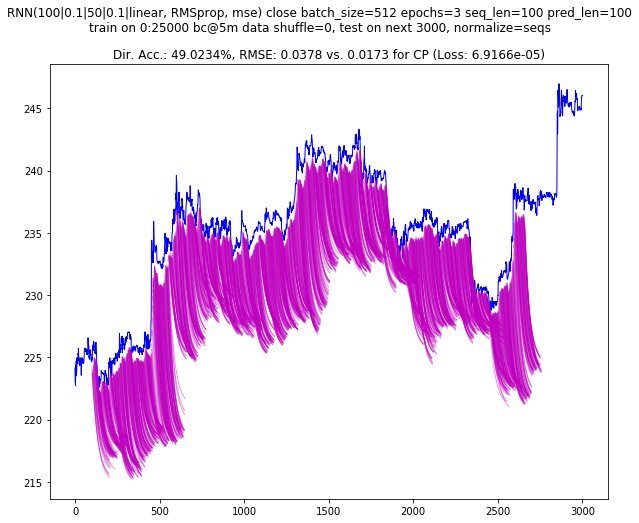

--- 436.872s to run segment



------ RUN 28000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140239284317776
Tensor("lstm_7_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 71,051
Tr

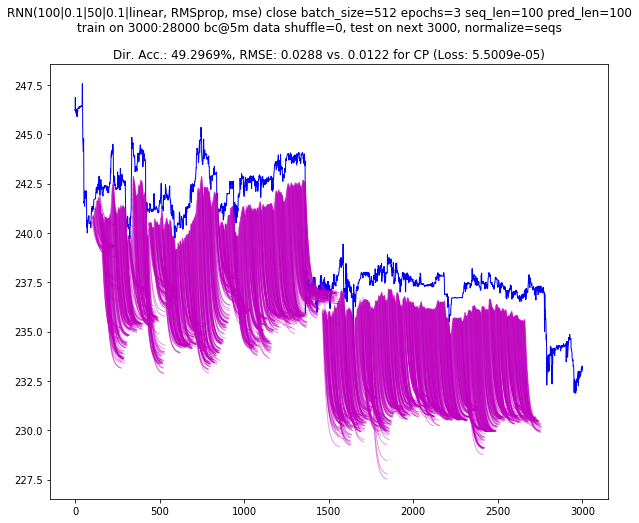

--- 437.124s to run segment



In [11]:
full_run(
    25000,
    25000 + 3000 * 2,
    write_csv_header=True
)



------ RUN 28000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238890929744
Tensor("lstm_9_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-tr

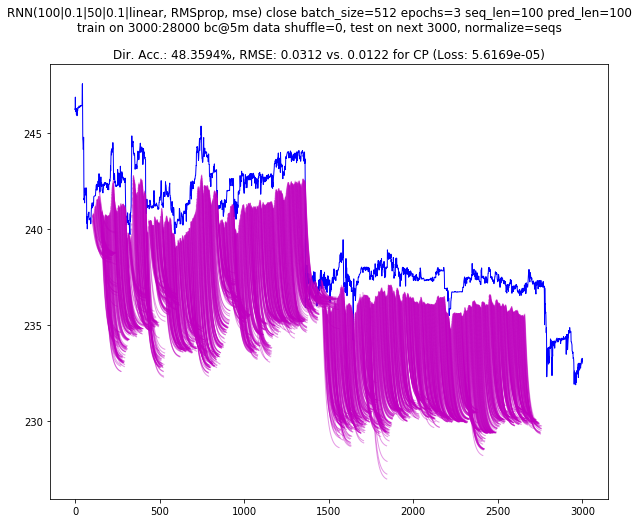

--- 438.548s to run segment



------ RUN 31000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238533555088
Tensor("lstm_11_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 71,051
T

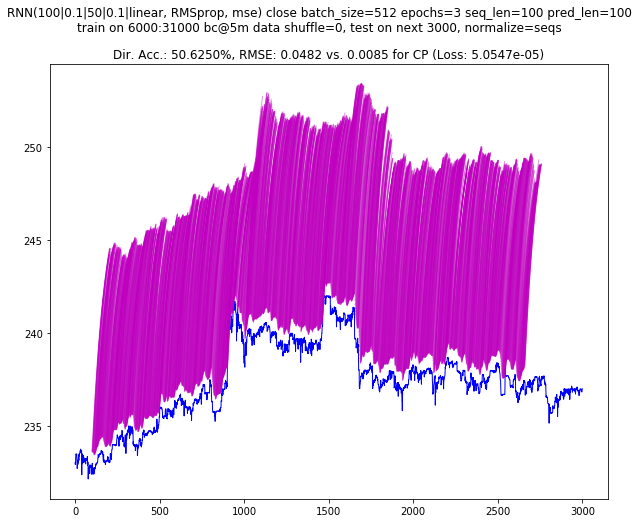

--- 440.190s to run segment



------ RUN 34000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238510291920
Tensor("lstm_13_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 71,051
T

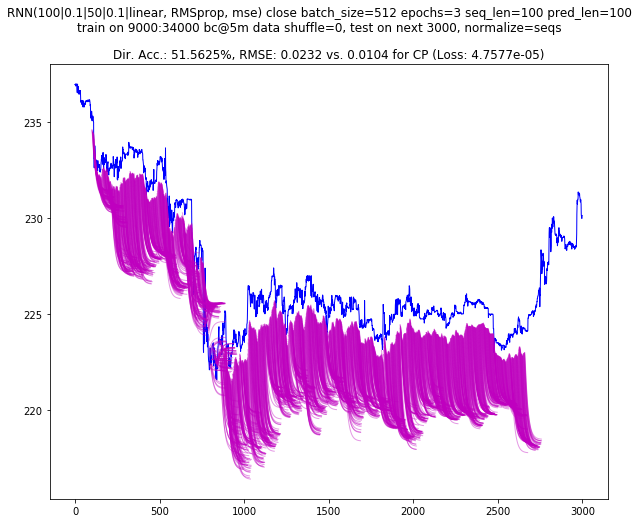

--- 440.599s to run segment



------ RUN 37000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140238526516496
Tensor("lstm_15_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 71,051
T

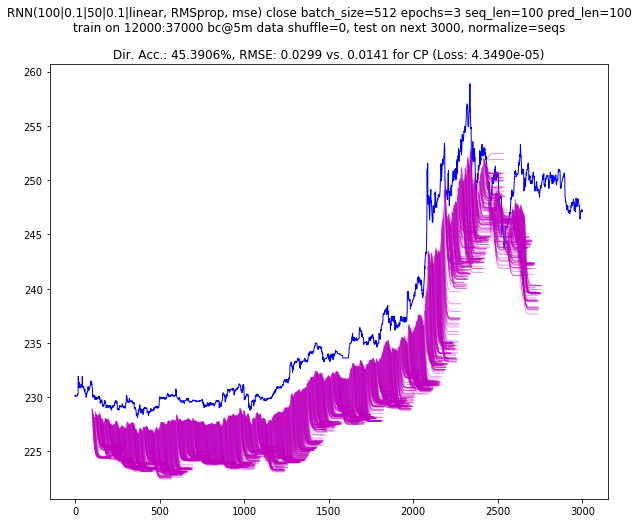

--- 442.890s to run segment



In [14]:
full_run(
    28000,
    28000 + 3000 * 4,
)



------ RUN 40000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238891635856
Tensor("lstm_17_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-t

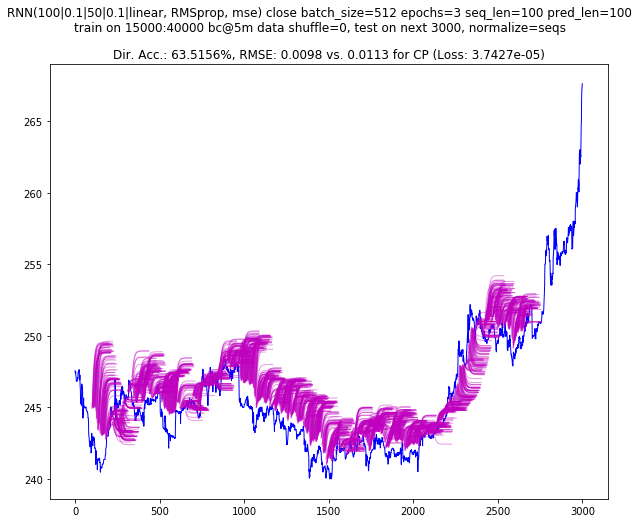

--- 439.782s to run segment



------ RUN 43000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140238903360720
Tensor("lstm_19_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 71,051
T

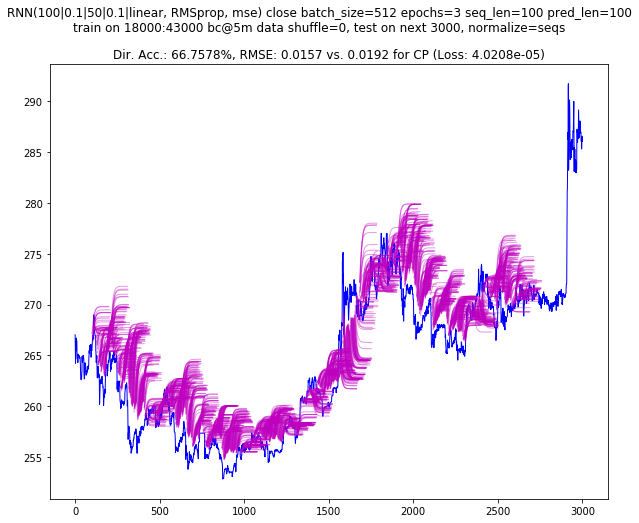

--- 440.717s to run segment



------ RUN 46000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238390134480
Tensor("lstm_21_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 71,051
T

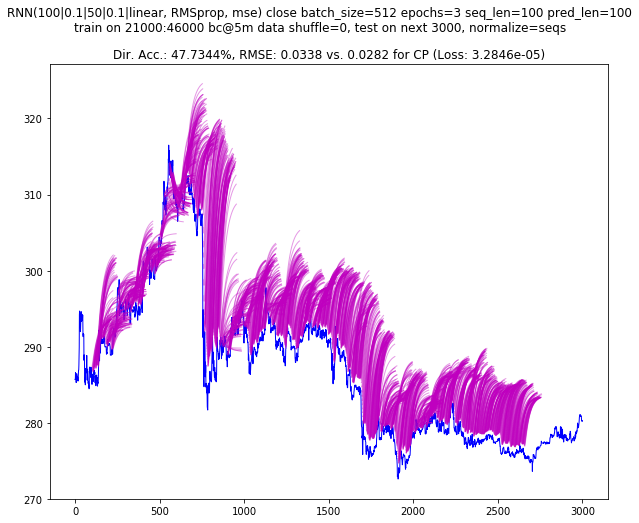

--- 440.908s to run segment



------ RUN 49000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140238401068304
Tensor("lstm_23_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_24 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 71,051
T

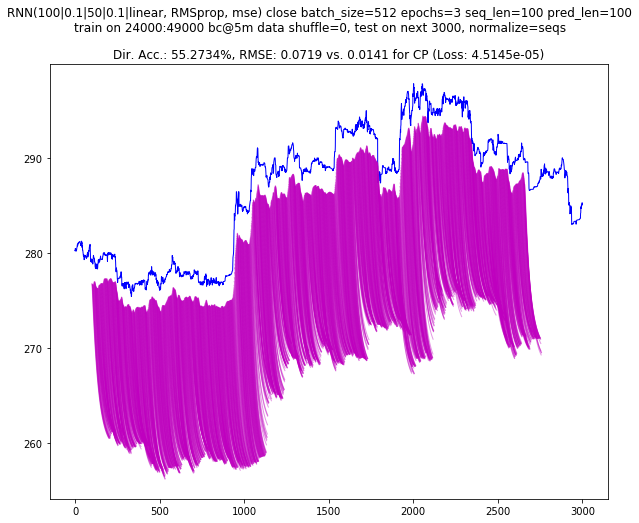

--- 437.297s to run segment



------ RUN 52000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238376656464
Tensor("lstm_25_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 71,051
T

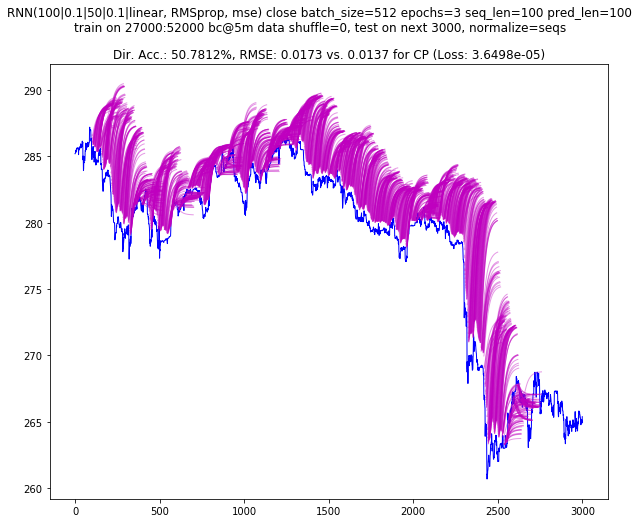

--- 440.145s to run segment



------ RUN 55000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140238433591760
Tensor("lstm_27_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_27 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_28 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 71,051
T

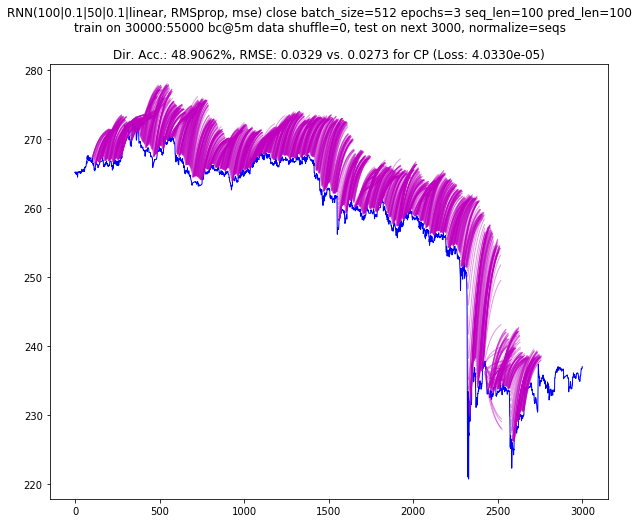

--- 438.367s to run segment



------ RUN 58000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238294842896
Tensor("lstm_29_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_30 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 71,051
T

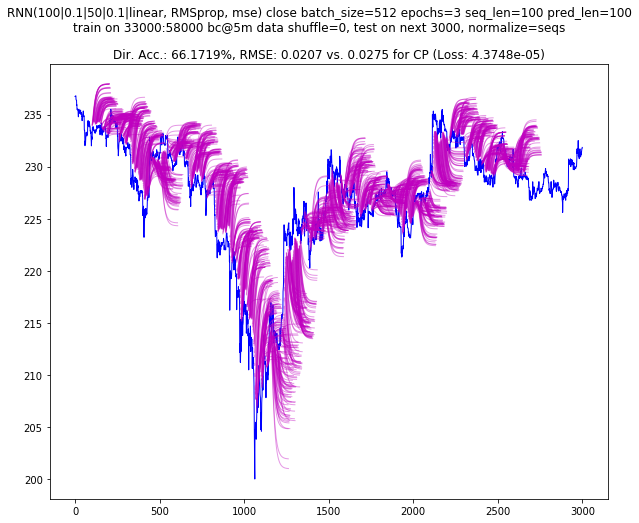

--- 442.754s to run segment



------ RUN 61000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238342861904
Tensor("lstm_31_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_31 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_32 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 71,051
T

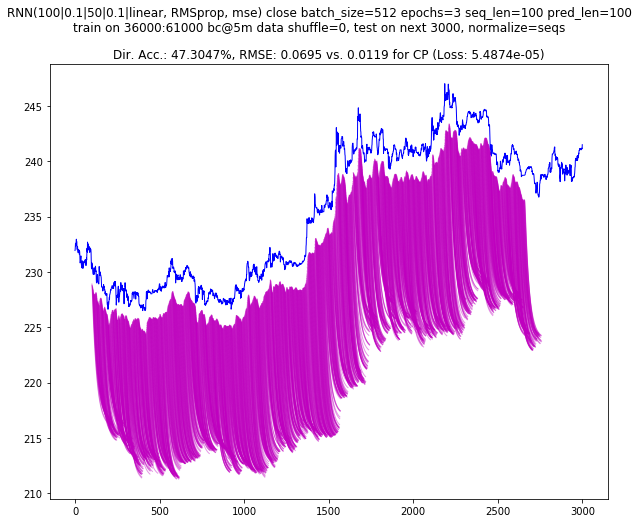

--- 439.958s to run segment



------ RUN 64000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238247618640
Tensor("lstm_33_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total params: 71,051
T

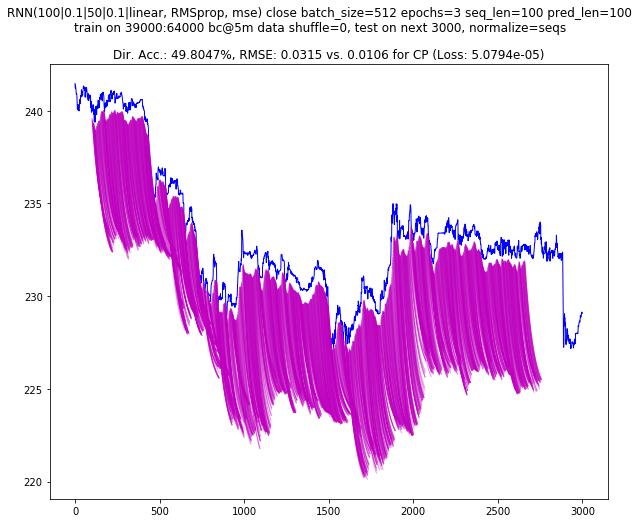

--- 443.478s to run segment



------ RUN 67000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238346291792
Tensor("lstm_35_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_35 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_36 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 71,051
T

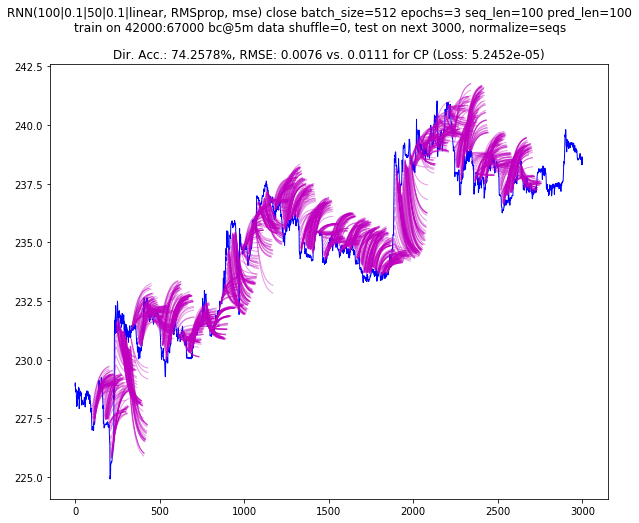

--- 441.669s to run segment



------ RUN 70000 ------

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238202402960
Tensor("lstm_37_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_37 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_38 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
Total params: 71,051
T

In [ ]:
full_run(
    40000,
    40000 + 3000 * 16,
)


   ------ RUN 88000 (from 63000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238092045136
Tensor("lstm_51_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_51 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params:

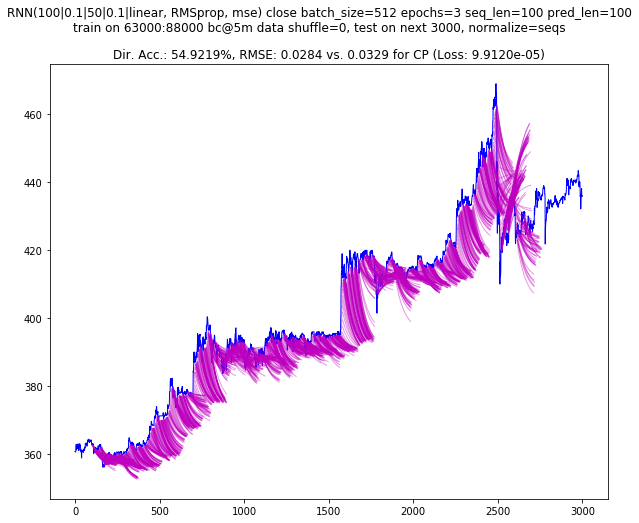

--- 445.727s to run segment


   ------ RUN 91000 (from 66000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238020295696
Tensor("lstm_53_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_53 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_54 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)            

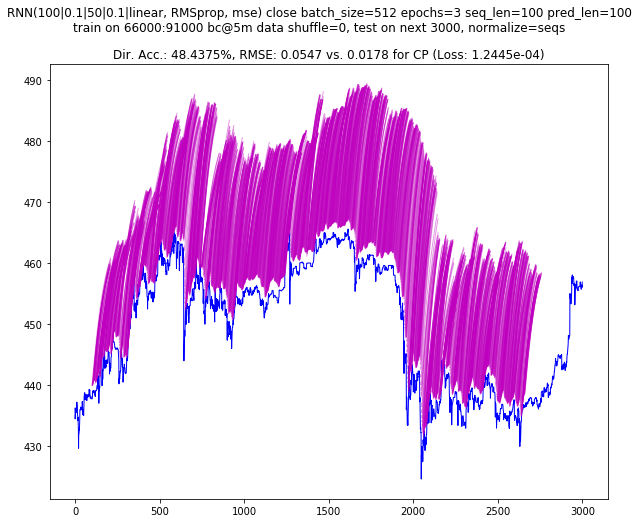

--- 443.053s to run segment


   ------ RUN 94000 (from 69000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140237963451344
Tensor("lstm_55_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_55 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_56 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)            

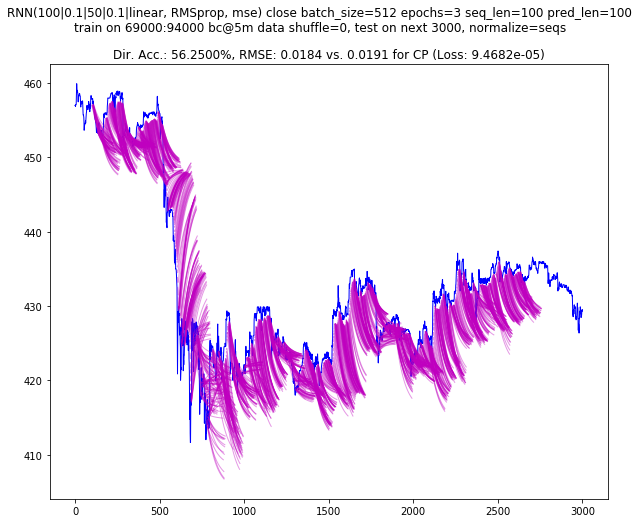

--- 446.905s to run segment


   ------ RUN 97000 (from 72000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140238051322128
Tensor("lstm_57_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_57 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_58 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)            

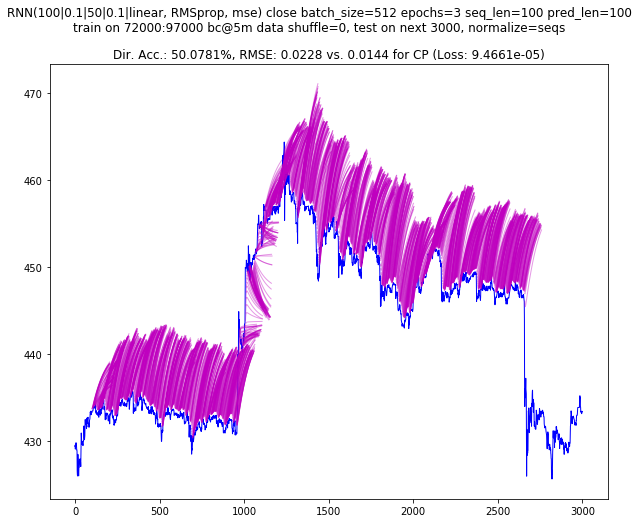

--- 445.927s to run segment


   ------ RUN 100000 (from 75000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140237966117328
Tensor("lstm_59_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_59 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_60 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)           

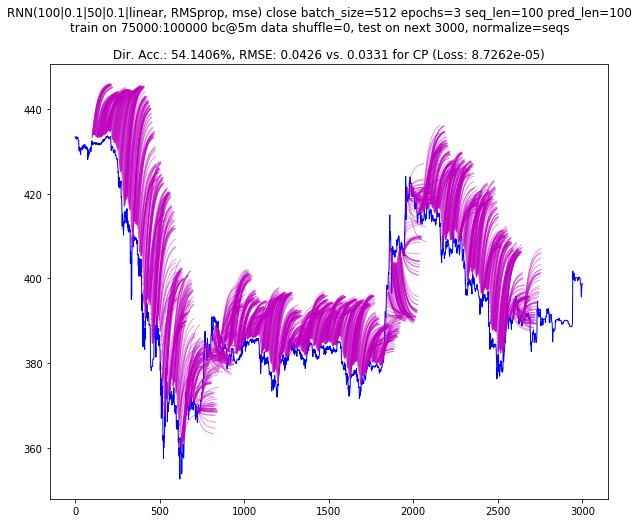

--- 447.844s to run segment


   ------ RUN 103000 (from 78000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140237895051472
Tensor("lstm_61_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_61 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_62 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)           

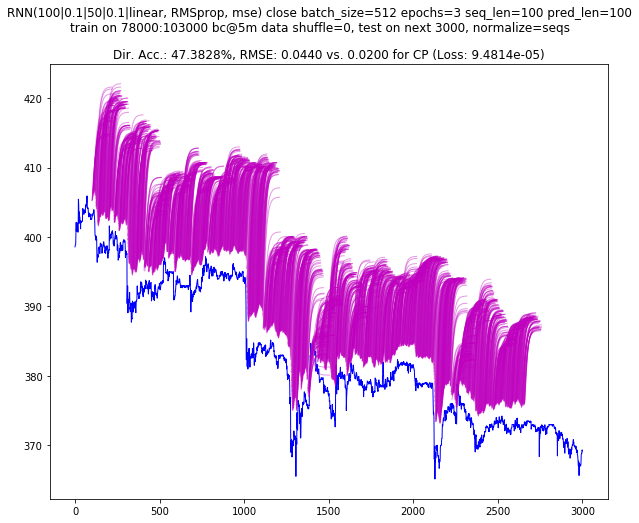

--- 448.326s to run segment


   ------ RUN 106000 (from 81000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140238025288336
Tensor("lstm_63_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_63 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_64 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)           

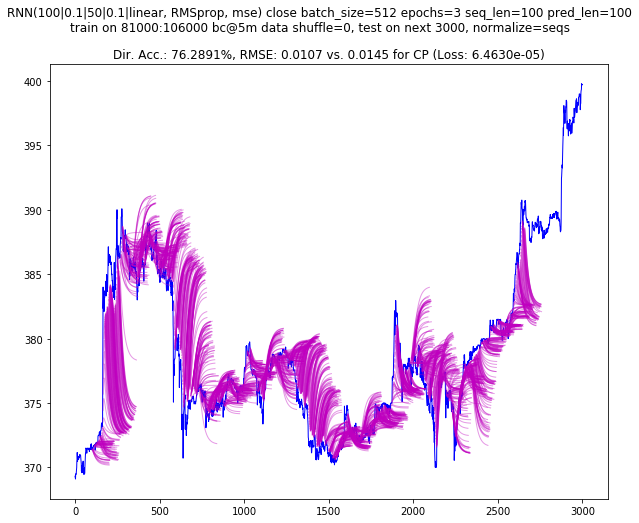

--- 448.041s to run segment


   ------ RUN 109000 (from 84000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.015s to model compilation time


--- Created model id: 140237919813072
Tensor("lstm_65_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_65 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_66 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)           

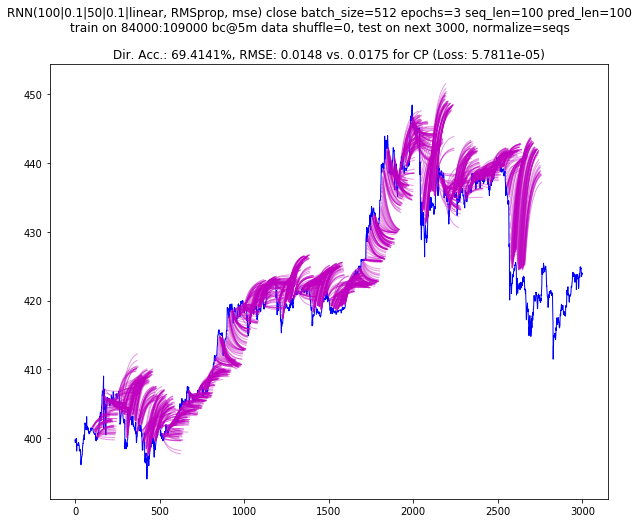

--- 484.367s to run segment

--- 3610.193s to full run 88000 - 112000



In [31]:
full_run(
    88000,
    88000 + 3000 * 8,
)


   ------ RUN 112000 (from 87000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140237826281168
Tensor("lstm_67_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_67 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_68 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 51        
Total params

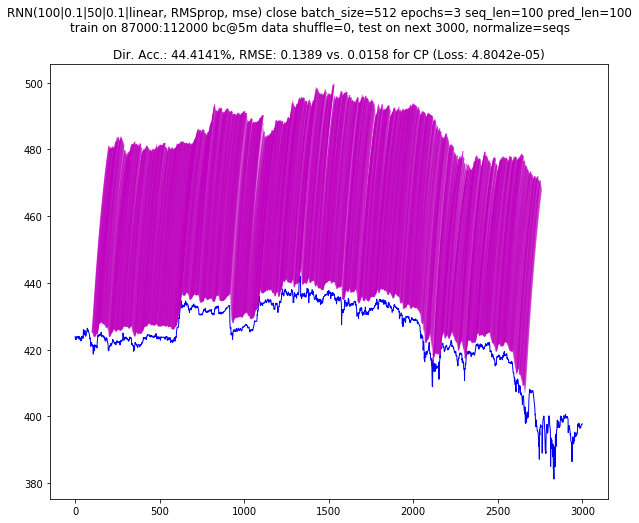

--- 544.165s to run segment


   ------ RUN 115000 (from 90000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.018s to model compilation time


--- Created model id: 140237771500304
Tensor("lstm_69_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_69 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_70 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)           

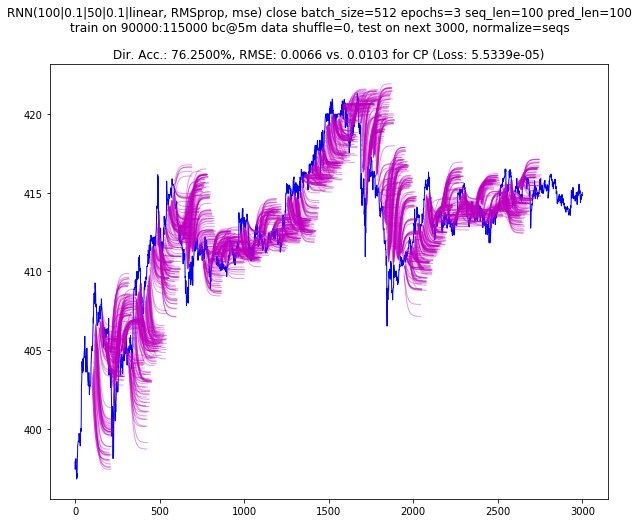

--- 555.481s to run segment


   ------ RUN 118000 (from 93000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.018s to model compilation time


--- Created model id: 140237987310992
Tensor("lstm_71_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_71 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_72 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)           

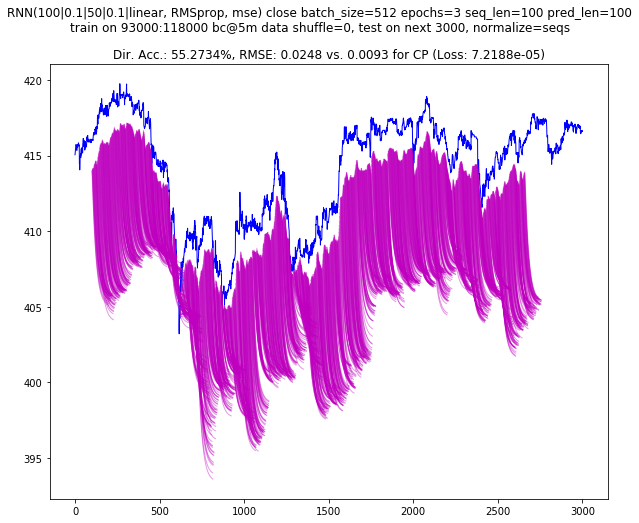

--- 550.348s to run segment


   ------ RUN 121000 (from 96000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.019s to model compilation time


--- Created model id: 140237838946960
Tensor("lstm_73_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_73 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_74 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)           

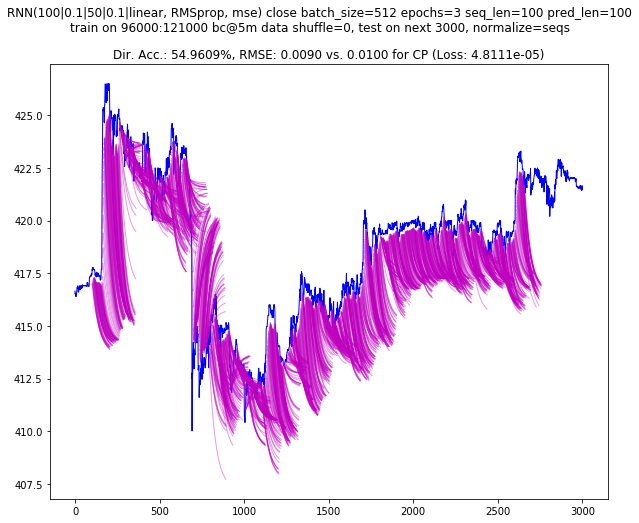

--- 548.936s to run segment


   ------ RUN 124000 (from 99000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.020s to model compilation time


--- Created model id: 140237739849488
Tensor("lstm_75_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_75 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_76 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_76 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)           

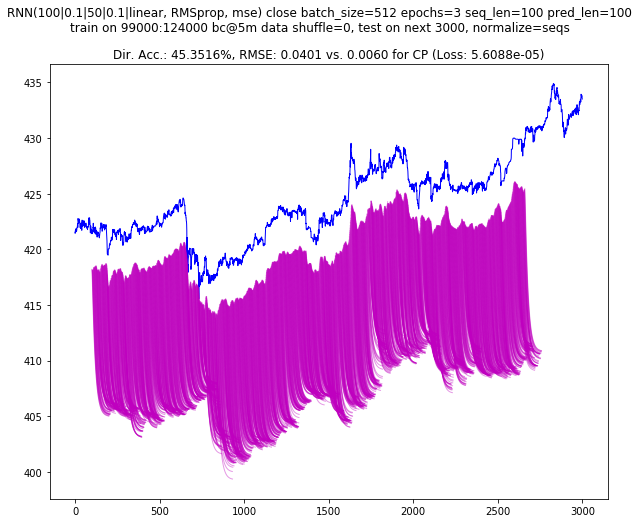

--- 547.100s to run segment


   ------ RUN 127000 (from 102000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.019s to model compilation time


--- Created model id: 140237679606736
Tensor("lstm_77_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_77 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_78 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_78 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)          

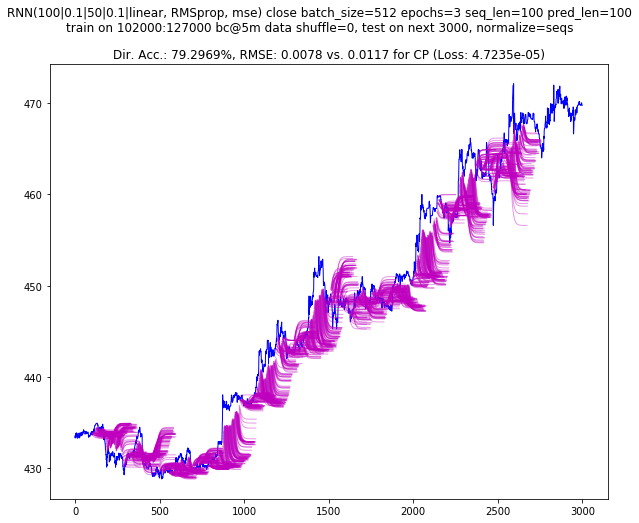

--- 564.108s to run segment


   ------ RUN 130000 (from 105000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.019s to model compilation time


--- Created model id: 140237989128912
Tensor("lstm_79_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_79 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_80 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_80 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)          

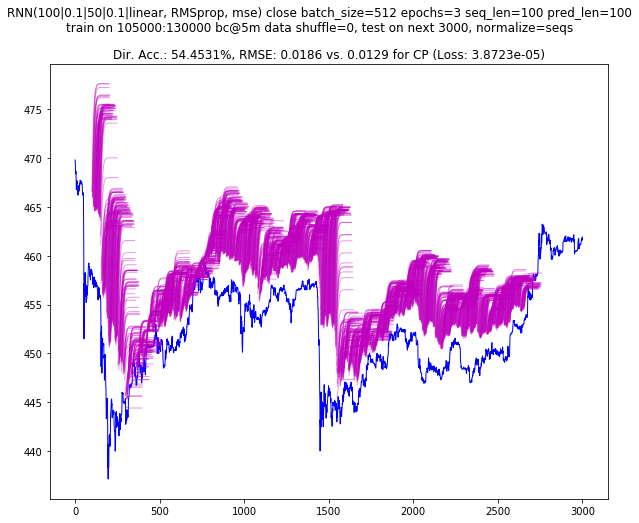

--- 571.369s to run segment


   ------ RUN 133000 (from 108000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.018s to model compilation time


--- Created model id: 140237777981264
Tensor("lstm_81_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_81 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_82 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_82 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)          

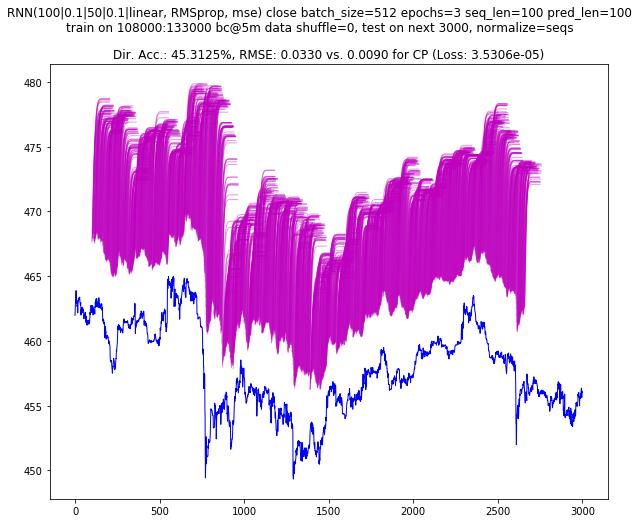

--- 564.401s to run segment

--- 4445.910s to full run 112000 - 136000



In [32]:
start_at = 88000 + 3000 * 8
full_run(
    start_at,
    start_at + 3000 * 8,
)


   ------ RUN 136000 (from 111000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140237644037328
Tensor("lstm_83_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_83 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_84 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_84 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 51        
Total param

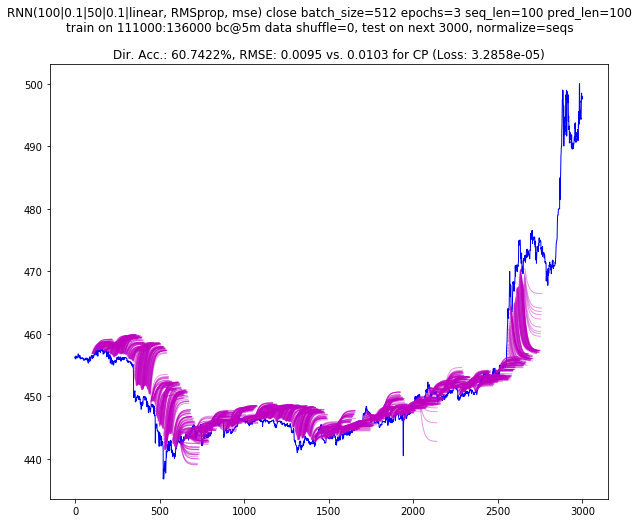

--- 567.389s to run segment


   ------ RUN 139000 (from 114000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.018s to model compilation time


--- Created model id: 140237587156176
Tensor("lstm_85_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_85 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_85 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_86 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_86 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)          

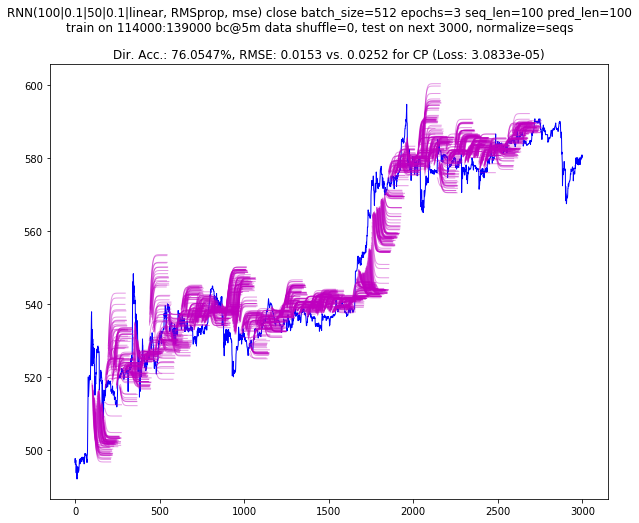

--- 573.080s to run segment


   ------ RUN 142000 (from 117000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.019s to model compilation time


--- Created model id: 140237535785744
Tensor("lstm_87_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_87 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_87 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_88 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_88 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)          

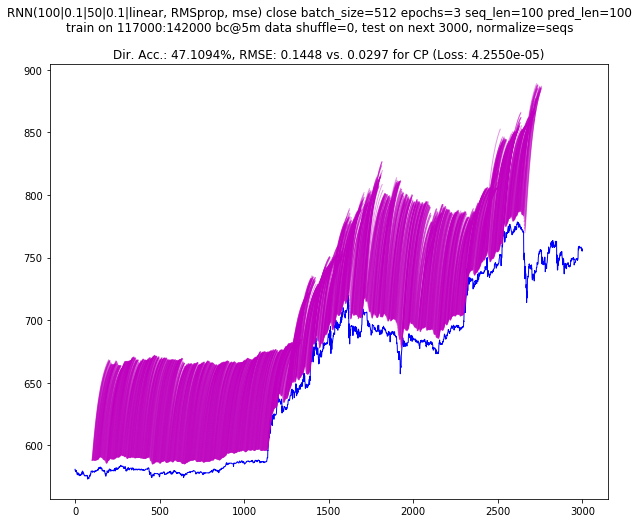

--- 575.245s to run segment


   ------ RUN 145000 (from 120000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.018s to model compilation time


--- Created model id: 140237648121232
Tensor("lstm_89_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_89 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_90 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_90 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)          

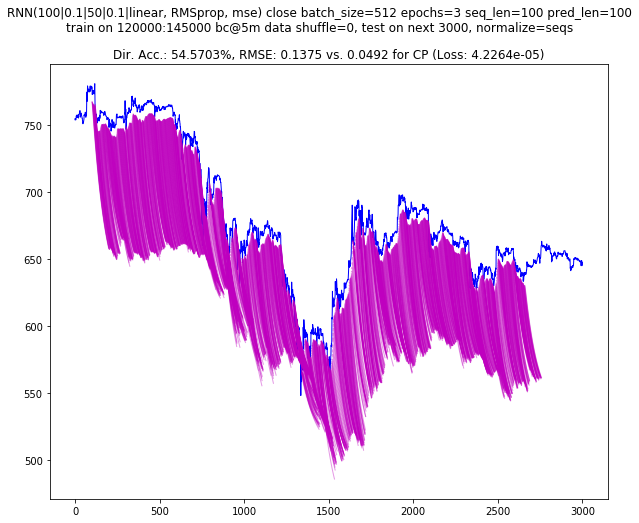

--- 573.159s to run segment


   ------ RUN 148000 (from 123000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.020s to model compilation time


--- Created model id: 140237649607440
Tensor("lstm_91_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_91 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_92 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_92 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)          

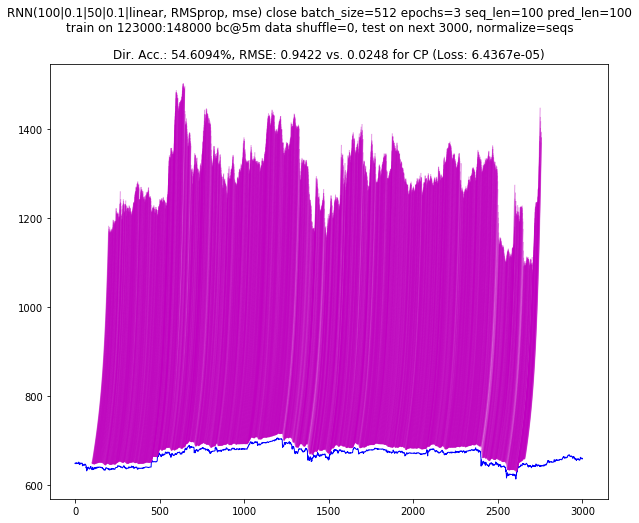

--- 569.198s to run segment


   ------ RUN 151000 (from 126000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.016s to model compilation time


--- Created model id: 140237543455312
Tensor("lstm_93_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_93 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_94 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_94 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)          

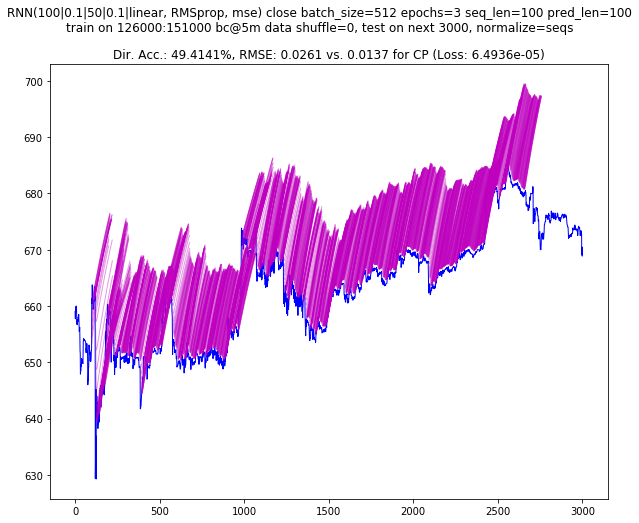

--- 496.655s to run segment


   ------ RUN 154000 (from 129000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140237473757328
Tensor("lstm_95_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_95 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_95 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_96 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_96 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)          

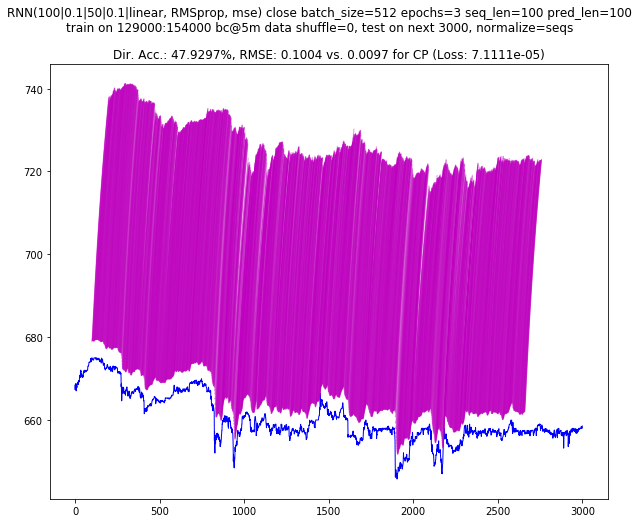

--- 495.256s to run segment


   ------ RUN 157000 (from 132000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140237416872208
Tensor("lstm_97_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_97 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_97 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_98 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)          

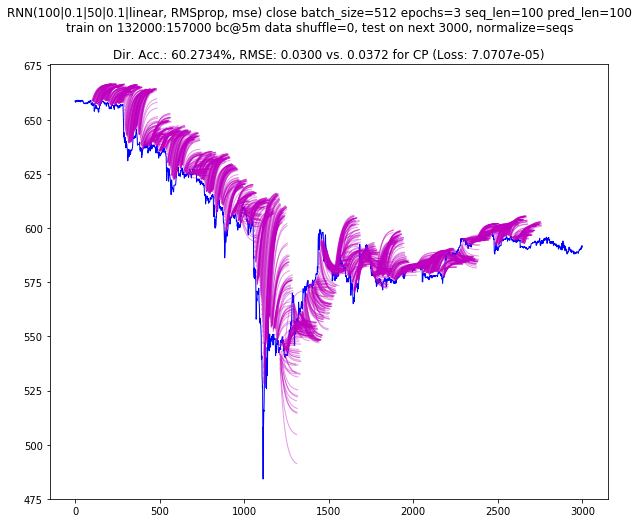

--- 500.457s to run segment

--- 4350.441s to full run 136000 - 160000



In [38]:
start_at = 136000
full_run(
    start_at,
    start_at + 3000 * 8,
)


   ------ RUN 160000 (from 135000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140237783638608
Tensor("lstm_99_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_99 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_100 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dropout_100 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 51        
Total param

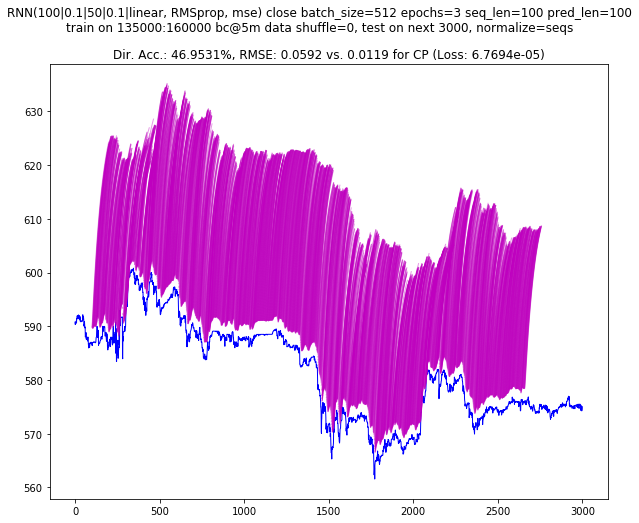

--- 506.784s to run segment


   ------ RUN 163000 (from 138000, train on 25000, test on 3000)

data ~ (28000, 1)
train_sz = 25000

seqs ~ (27899, 101, 1)
--- 0.017s to model compilation time


--- Created model id: 140237557971088
Tensor("lstm_101_input:0", shape=(?, 100, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_101 (LSTM)              (None, 100, 100)          40800     
_________________________________________________________________
dropout_101 (Dropout)        (None, 100, 100)          0         
_________________________________________________________________
lstm_102 (LSTM)              (None, 50)                30200     
_________________________________________________________________
dropout_102 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)         

In [ ]:
start_at = 160000
full_run(
    start_at,
    start_at + 3000 * 8,
)